# PRF FITTING WITH BRAINCODER

In [1]:
%load_ext autoreload
%autoreload 2
# First lets load some packages
import matplotlib.pyplot as plt
import os
opj = os.path.join
import numpy as np
import scipy.io as sio
import tensorflow as tf
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)
# tf.config.set_visible_devices([], 'GPU')
from dpu_mini.fs_tools import *
from dpu_mini.mesh_maker import *
from dpu_mini.stats import *
import pandas as pd
import pickle



Could not find FS_LICENSE
Uncomment line below and specify path to FS_LICENSE


# Load design matrix
If you've previously run "samsrf" or mrvista style PRF mapping, then you likely have a .mat file which stores your design matrix. No worries, we can load that here. Otherwise we just want a numpy array of size 
```n_pixels * n_pixels * time```

Having a very high resolution design matrix can slow things down a bit. For this notebook I've done some aggressive downsampling so we can run along quickly

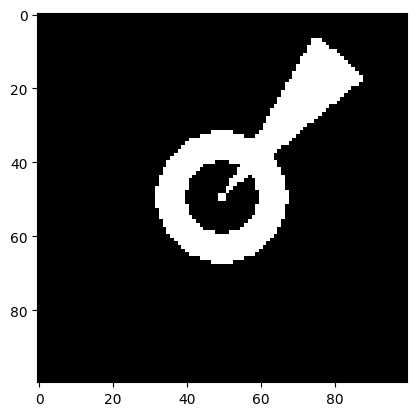

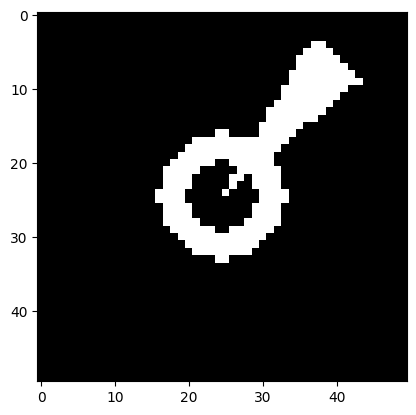

In [2]:
dm_path = './aps_pRF.mat'
dm_data = sio.loadmat(dm_path)
dm_in = dm_data['ApFrm']
plt.imshow(dm_in[:,:,51], cmap='gray')
from scipy.ndimage import zoom


og_pix = dm_in.shape[0]
n_pix = 50
pix_ratio = n_pix / og_pix
dm = zoom(dm_in, (pix_ratio, pix_ratio, 1), order=0)  # nearest-neighbor
plt.figure()
plt.imshow(dm[:,:,51], cmap='gray')


# LOAD DATA     

In [ ]:
from dpu_mini.utils import *
import nibabel as nib
gii_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/sf2_mcalign/sub-hp01/ses-01'
gii_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/sf2_reg_mocoAFNITOP/sub-hp01/ses-01'
gii_files = os.listdir(gii_folder)
gii_files = [f for f in gii_files if '.gii' in f]
gii_files = [f for f in gii_files if 'SMOOTH' not in f]

print(len(gii_files))
# bloop
# bloop
# load as arrays LE & RE 
data = {}
for task in ['pRFLE', 'pRFRE']:
    t_files = [f for f in gii_files if task in f]
    hemi_data = {}
    for hemi in ['L', 'R']:
        thisf = [f for f in t_files if f'hemi-{hemi}' in f]
        tdata = []
        for tgii in thisf:
            tgii_nib = nib.load(opj(gii_folder, tgii))
            tgii_data = [i.data for i in tgii_nib.darrays]
            tgii_data = np.array(tgii_data)[4:,:] # drop first 4 trigger scans             
            tgii_data = dag_detrending(tgii_data.T, detrend_param=2).T
            # tgii_data = dag_psc(tgii_data.T).T
            tdata.append(tgii_data)
            # break
        hemi_data[hemi] = np.mean(tdata, axis=0)
        print(hemi_data[hemi].shape)
        # tRf = [f for f in t_files if 'hemi-R' in f]
        # print(tL)   
    data[task] = pd.DataFrame(np.hstack([
        hemi_data['L'], hemi_data['R']
    ]))



In [ ]:
import os
pyb_folder = '/Users/marcusdaghlian/CVL Dropbox/Marcus  Daghlian/240522NG/hypot/derivatives/pybest20/sub-hp01/ses-fprep/denoising'
pyb_files = os.listdir(pyb_folder)
pyb_files = [p for p in pyb_files if 'bold' in p]
data = {}
for task in ['pRFLE', 'pRFRE']:
    t_files = [f for f in pyb_files if task in f]
    t_files = [f for f in t_files if 'run' in f]
    print(t_files)
    hemi_data = {}
    for hemi in ['L', 'R']:
        thisf = [f for f in t_files if f'hemi-{hemi}' in f]
        tdata = []
        for tnpy in thisf:
            tdata.append(np.load(opj(pyb_folder,tnpy))[4:,:])
        hemi_data[hemi] = np.mean(tdata, axis=0)
        print(hemi_data[hemi].shape)
    data[task] = pd.DataFrame(np.hstack([
        hemi_data['L'], hemi_data['R']
    ]))



In [ ]:
i =0
plt.plot(data['pRFLE'].iloc[:,i])
plt.plot(data['pRFRE'].iloc[:,i])

# plt.plot(datap[task].iloc[:,i])

In [ ]:
datap[task].shape

In [ ]:
data[task]

In [ ]:
fs_dir = '/Users/marcusdaghlian/projects/dp-clean-link/240522NG/hypot/derivatives/freesurfer'
sub = 'sub-hp01'
# v1 = dag_load_roi(sub, 'b14_V', fs_dir, combine_matches=True)
# v1_ts = data['pRFLE'].iloc[:,v1]

In [ ]:
from braincoder.optimize import *
from braincoder.models import GaussianPRF2DWithHRF, ContrastSensitivityWithHRF, DifferenceOfGaussiansPRF2DWithHRF, DivisiveNormalizationGaussianPRF2DWithHRF, CompressiveSpatialGaussiansPRF2DWithHRF
from braincoder.hrf import SPMHRFModel, CustomHRFModel, HRFModel

paradigm = np.rollaxis(dm, 2, 0) # time; x ; y
scrn_dist_cm = 34
scrn_diam_cm = 27
angle_rad = 2 * np.arctan(scrn_diam_cm / (2 * scrn_dist_cm))    
# Convert radians to degrees
angle_deg = np.degrees(angle_rad)
radius_deg = angle_deg / 2.0
radius_vert = radius_deg
radius_horiz = radius_deg
print(f'Radius in degrees = {radius_deg:.3f}')
tr = 1.0
x_grid, y_grid = np.meshgrid(
    np.linspace(-radius_horiz, radius_horiz, dm.shape[1]),
    np.linspace(-radius_vert, radius_vert, dm.shape[0])
    )
y_grid *= -1

grid_coordinates = np.stack((x_grid.ravel().astype(np.float32), y_grid.ravel().astype(np.float32)), 1)




# Create the model using the loaded HRF parameter from the YAML config
model = GaussianPRF2DWithHRF(
    grid_coordinates, 
    paradigm=paradigm,
    hrf_model=SPMHRFModel(tr=tr), 
    flexible_hrf_parameters=True,
    )        

#     model = DivisiveNormalizationGaussianPRF2DWithHRF(
#         grid_coordinates, 
#         paradigm=paradigm,
#         hrf_model=SPMHRFModel(tr=dm.TR), 
#         flexible_hrf_parameters=flexible_hrf_parameters,
#         )                    

#     model = DifferenceOfGaussiansPRF2DWithHRF(
#         grid_coordinates, 
#         paradigm=paradigm,
#         hrf_model=SPMHRFModel(tr=dm.TR), 
#         flexible_hrf_parameters=flexible_hrf_parameters,
#         )     

csmodel = CompressiveSpatialGaussiansPRF2DWithHRF(
    grid_coordinates, 
    paradigm=paradigm,
    hrf_model=SPMHRFModel(tr=1.0), 
    flexible_hrf_parameters=True,
    )                                            

cfg = {}
cfc = {}
for task in data.keys():
    cfg[task] = ParameterFitter(
        model, data[task], model.paradigm,
        # memory_limit=666666666//10
        )    
    cfc[task] = ParameterFitter(
        csmodel, data[task], model.paradigm,
        # memory_limit=666666666//10
        )    


In [ ]:
pars = {
    'x' : np.array([-radius_deg,radius_deg,3]),
    'y' : np.array([-radius_deg,radius_deg,3]), 
    'sd' : np.array([10,1,2]),
    'baseline' : np.array([0.0, 0.0, 0.0, ]), 
    'amplitude' : np.array([10, 10, 10, ]),
    'hrf_delay' : np.array([1.0, 1.0, 1.0]),
    'hrf_dispersion' : np.array([1.0, 1.0, 1.0]),
}
import pandas as pd 
pars = pd.DataFrame(pars)
pars
a = model.predict(parameters=pars)
plt.plot(a.iloc[:,0])
plt.plot(a.iloc[:,1])

# CSS model

In [ ]:
# test cs

bounds       = {
    'x' : [-radius_deg, radius_deg], 
    'y' : [-radius_deg, radius_deg], 
    'exponent' :[.1, 3],
    'sd': [.1, radius_deg*1.5], 

    # ''
}
grid_points = 20
cp = {}

for k in data.keys():    
    tcp = cfc[k].fit_grid(
        x       = np.linspace(bounds['x'][0], bounds['x'][1], 10),
        y       = np.linspace(bounds['y'][0], bounds['y'][1], 10),
        sd      = np.linspace(bounds['sd'][0], 8, 5),
        exponent= np.array([0.9, 1.0, 1.1]),
        amplitude   = [1.0],
        baseline    = [0.0],
        use_correlation_cost = True, 
        hrf_delay = [6.0], 
        hrf_dispersion = [1.0],
        # **hrf_kwargs        
    )
    cp[k] = cfc[k].refine_baseline_and_amplitude(parameters=tcp, )
    cp[k]['r2'] = cfc[k].get_rsq(parameters=cp[k], )

    print(cp[k]['r2'].mean())
    print(cp[k]['r2'].max())

In [ ]:
iter = {}
for k in data.keys():

    grid_pars_full = cp[k].copy()
    amp_tiny = (grid_pars_full['amplitude']<0.01).to_numpy()
    grid_pars_full['amplitude'].iloc[amp_tiny] = 0.10
    # SPLIT INTO 10 BATCHES TO SAVE MEMORY
    n_splits = 10
    n_vx = cp[k].shape[0]
    split_size = n_vx // n_splits
    iter_pars_list = []
    r2_list = []
    for i_split in range(n_splits):
        print(f'Fitting split {i_split+1}/{n_splits}')
        if i_split == n_splits - 1:
            split_idx = np.arange(i_split*split_size, n_vx)
        else:
            split_idx = np.arange(i_split*split_size, (i_split+1)*split_size)
        split_idx = [i for i in split_idx if i < n_vx]
        grid_pars_split = grid_pars_full.iloc[split_idx, :].copy()
        tpsc = data[k].iloc[:, split_idx].copy()    
            
        tcf = ParameterFitter(
            csmodel, tpsc, model.paradigm,
            # memory_limit=666666666//10
            )
        # [1] -> quick iter
        iter_pars = tcf.fit(
            init_pars=grid_pars_split, 
            max_n_iterations=10,  
            learning_rate=0.01,
            fixed_pars={'hrf_dispersion':1.0, 'hrf_delay':6.0, 'exponent' : 1.0}
            )   
        tr2 = tcf.get_rsq(parameters=iter_pars)
        print(f'Pre refine m = {tr2.mean():.3f}')
        # -> then refine...
        iter_pars_split = tcf.refine_baseline_and_amplitude(
            parameters=iter_pars)
        tr2 = tcf.get_rsq(parameters=iter_pars_split)
        print(f'Post refine m = {tr2.mean():.3f}')
        bloop
        # [2] Now main fitting
        # iter_pars2 = tcf.fit(
        #     init_pars=iter_pars1, 
        #     max_n_iterations=500,  
        #     learning_rate=0.01,
        #     )  
        # # -> refine again
        # iter_pars2 = tcf.refine_baseline_and_amplitude(
        #     parameters=iter_pars2)
        # # -> one last quick run 
        # iter_pars_split = tcf.fit(
        #     init_pars=iter_pars2, 
        #     max_n_iterations=100,  
        #     learning_rate=0.01,
        #     )   
            
        r2 = tcf.get_rsq(parameters=iter_pars_split)
        r2_list.append(r2)     
        iter_pars_list.append(iter_pars_split)
    iter_pars = pd.concat(iter_pars_list, axis=0)
    r2 = np.concatenate(r2_list, axis=0) 
    print(iter_pars.shape)
    iter_pars['r2'] = r2
    iter[k] = iter_pars.copy()


In [ ]:
grid_pars_split['exponent'].min()

# Gauss model 

In [ ]:

bounds       = {
    'x' : [-radius_deg, radius_deg], 
    'y' : [-radius_deg, radius_deg], 
    'sd': [.1, radius_deg*1.5], 

    # ''
}
grid_points = 20
gp = {}
for k in data.keys():
    tpickle = f'hp01_prf_grid{k}_pybtopnosmooth.pkl'
    if os.path.exists(tpickle):
        with open(tpickle, 'rb') as f:
            gp[k]=pickle.load(f)
    else:
        tgp = cfg[k].fit_grid(
            x       = np.linspace(bounds['x'][0], bounds['x'][1], 15),
            y       = np.linspace(bounds['y'][0], bounds['y'][1], 15),
            sd      = np.linspace(bounds['sd'][0], 8, 10),
            amplitude   = [1.0],
            baseline    = [0.0],
            use_correlation_cost = True, 
            hrf_delay = [6.0], 
            hrf_dispersion = [1.0],
            # **hrf_kwargs        
        )
        gp[k] = cfg[k].refine_baseline_and_amplitude(parameters=tgp, )
        gp[k]['r2'] = cfg[k].get_rsq(parameters=gp[k], )
        with open(tpickle, 'wb') as f:
            pickle.dump(gp[k], f)

        print(gp[k]['r2'].mean())
        print(gp[k]['r2'].max())

In [ ]:
gp = {}
for k in data.keys():
    for k2 in ['afni', 'fsl', 'pyb']:
        tpickle = f'hp01_prf_grid{k}_{k2}topnosmooth.pkl'
        with open(tpickle, 'rb') as f:
            gp[f'{k}{k2}']=pickle.load(f)


In [ ]:
mask = gp['pRFLEaf']['r2']>0.1
mask &= gp['pRFLEfs']['r2']>0.1
mask = mask.to_numpy()
dag_scatter(
    gp['pRFLEaf']['x'].iloc[mask], 
    gp['pRFLEfs']['x'].iloc[mask], 
    do_id_line=True, 
    do_line=True, 
    do_corr=True, 
)


In [ ]:
dag_scatter(
    gp['pRFLEafni']['r2'],
    gp['pRFLEpyb']['r2'], 
    do_id_line=True, 
)

In [ ]:
v1 = dag_load_roi(sub, 'b14_V', fs_dir, combine_matches=True)
plt.hist(
    (gp['pRFLEfsl']['r2']-gp['pRFLEpyb']['r2']).iloc[v1], 
    bins=np.linspace(-.5, .5, 20)
)
(gp['pRFLEafni']['r2']-gp['pRFLEpyb']['r2']).iloc[v1].median()

In [ ]:
hrf_fixed = {
    'hrf_delay' : [6.0], 
    'hrf_dispersion': [1.0],
}
iter = {}
for k in data.keys():
    iter_file =  f'hp01_prf_iter{k}_pybdm30.pkl'
    if os.path.exists(iter_file):
        with open(iter_file, 'rb') as f:
            iter[k] = pickle.load(f).copy()
        print(f'found {k}')
    else:
        print(f'running {k}')
        grid_pars_full = gp[k].copy()
        # SPLIT INTO 10 BATCHES TO SAVE MEMORY
        n_splits = 5
        n_vx = gp[k].shape[0]
        split_size = n_vx // n_splits
        if True:
            # --- RANDOM SPLIT LOGIC ---
            # Generate a shuffled array of all indices
            indices = np.arange(n_vx)
            np.random.seed(0)
            np.random.shuffle(indices)
            # Split the shuffled indices into n_splits arrays
            index_splits = np.array_split(indices, n_splits)
            # ---------------------------
        else:
            indices = np.arange(n_vx)
            index_splits = np.array_split(indices, n_splits)
        with open('idx.pkl', 'wb') as f:
            pickle.dump(index_splits, f)
        iter_pars_list = []
        r2_list = []
        
        for i_split, split_idx in enumerate(index_splits):
            trpick = f'spybR{i_split}{k}.pkl'
            
            grid_pars_split = grid_pars_full.iloc[split_idx, :].copy()
            tpsc = data[k].iloc[:, split_idx].copy()    
                
            tcf = ParameterFitter(
                model, tpsc, model.paradigm,
                # memory_limit=666666666//10
                )
            if os.path.exists(trpick):
                with open(trpick, 'rb') as f:
                    iter_pars_split = pickle.load(f)
                r2 = tcf.get_rsq(parameters=iter_pars_split)
            else:
                print(f'Fitting split {i_split+1}/{n_splits}')

                # [1] -> quick iter
                iter_pars_split = tcf.fit(
                    init_pars=grid_pars_split, 
                    max_n_iterations=100,  
                    learning_rate=0.1,
                    )   
                iter_pars_split['temp_orig_idx'] = split_idx
                # -> then refine...
                # iter_pars_split = tcf.refine_baseline_and_amplitude(
                #     parameters=iter_pars1)   
                # [2] Now main fitting
                # iter_pars2 = tcf.fit(
                #     init_pars=iter_pars1, 
                #     max_n_iterations=500,  
                #     learning_rate=0.01,
                #     )  
                # # -> refine again
                # iter_pars2 = tcf.refine_baseline_and_amplitude(
                #     parameters=iter_pars2)
                # # -> one last quick run 
                # iter_pars_split = tcf.fit(
                #     init_pars=iter_pars2, 
                #     max_n_iterations=100,  
                #     learning_rate=0.01,
                #     )   
                with open(trpick, 'wb') as f:
                    pickle.dump(iter_pars_split, f)
            r2 = tcf.get_rsq(parameters=iter_pars_split)
            r2_list.append(r2)     
            iter_pars_list.append(iter_pars_split)
        # Combine all splits
        iter_pars_combined = pd.concat(iter_pars_list, axis=0)
        # SORT back to original voxel order and clean up
        iter_pars = iter_pars_combined.sort_values('temp_orig_idx').drop(columns=['temp_orig_idx'])
        r2 = np.concatenate(r2_list, axis=0) 
        print(iter_pars.shape)
        iter_pars['r2'] = r2
        iter[k] = iter_pars.copy()
        with open(iter_file, 'wb') as file:
            pickle.dump(iter[k], file)

In [ ]:
split_idx

In [ ]:
with open(f'hp01_prf_iterpRFLE_pybtopnosmooth', 'rb') as file:
    itp = pickle.load(file)

In [ ]:
iter['pRFLE'] - iter['pRFRE']

In [ ]:
hrf_fixed = {
    'hrf_delay' : [6.0], 
    'hrf_dispersion': [1.0],
}
iter = {}
for k in data.keys():
    
    with open(f'hp01_prf_iter{k}_afnitopnosmoothQ.pkl', 'rb') as file:
        iter[k] = pickle.load(file)
    iter[k]['r2']

# PRF OBJ

In [ ]:
from hypot.code.hypot_code.postproc.prf_obj import *
prf_objs = []
prf_ids = []
for k in data.keys():
    prf_objs.append(PrfObj(
        pd_params=iter[k], 
        bcoder_model=model, 
        data=data[k], 
        model='gauss', 
    )
    )
    prf_ids.append(k)
po = PrfMulti(prf_objs, prf_ids)

In [ ]:
po.add_prf_diff('pRFLE', 'pRFRE')

In [ ]:
%matplotlib inline
a =po.po['pRFLE'].prf_plotter(62, do_str=True)
plt.show()
plt.figure()

# Surface plotting

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dpu_mini.mesh_dash import dag_mesh_pickle, MeshDash

In [ ]:
sub = 'sub-hp01'
fs_dir = '/Users/marcusdaghlian/projects/dp-clean-link/240522NG/hypot/derivatives/freesurfer'
fs = MeshDash(
    sub, 
    fs_dir=fs_dir,
    output_dir='z_dash',
    )
fs.web_get_ready()
for k in po.pd_params.keys():
    col_kwargs = {
    }
    if 'pol' in k:
        col_kwargs['vmin'] = -np.pi
        col_kwargs['vmax'] = np.pi
        col_kwargs['cmap'] = 'marco_pol'
    elif 'ecc' in k:
        col_kwargs['vmin'] = 0
        col_kwargs['vmax'] = radius_deg
        col_kwargs['cmap'] = 'jet'
    elif 'r2' in k:
        col_kwargs['vmin'] = 0
        col_kwargs['vmax'] = 1.0
        col_kwargs['cmap'] = 'plasma'
    elif ('x' in k) or ('y' in k):
        col_kwargs['vmin'] = -10
        col_kwargs['vmax'] = 10
        col_kwargs['cmap'] = 'RdBu_r'
    ktask = k.split('-')[0]
    fs.web_add_vx_col(
        data=po.pd_params[k],
        data4mask=po.pd_params[f'{ktask}-r2'],
        vx_col_name=k.replace('-','_'), 
        rsq_thresh=0.1, 
        **col_kwargs
    )

for k in po.po['diff_pRFLE_pRFRE'].pd_params.keys():
    fs.web_add_vx_col(
        data=po.po['diff_pRFLE_pRFRE'].pd_params[f'{k}'],
        # data4mask=,
        vx_col_name=f"diff_{k.replace('-','_')}", 
        cmap='RdBu_r',
        # **col_kwargs
    )
# Other cool things....
# you can add ROIs

# fs.web_add_roi(roi_list='V1')
roi_list = dag_roi_list_expand(sub, 'b14_', fs_dir)[1:]
fs.web_add_roi(roi_list=roi_list)
# You can also add conditional functions to do plotting. 
# For example if you have a function to plot the timeseries put that here 
def my_plot_function(vertex_id):
    fig = plt.figure()
    
    # Do some plotting based on the vertex...
    return fig

# We have already made one here -> 

fs.web_add_mpl_fig_maker(
    mpl_func=po.po['pRFLE'].prf_plotter, # my_plot_function
    mpl_key='pRFLE',
    mpl_kwargs={'do_str':True},
) # you can add more than one...
fs.web_add_mpl_fig_maker(
    mpl_func=po.po['pRFRE'].prf_plotter, # my_plot_function
    mpl_key='pRFRE',
    mpl_kwargs={'do_str':True},
)
# Other cool things....
# you can add ROIs
# fs.web_add_roi(roi_list='V1')

# We have already made one here -> 


In [ ]:
app = fs.web_launch_with_dash() # change to exciting to use silly fonts...
# Open the app in a browser (or in the notebook)
app.run(mode='external', host='127.0.0.1', port=8000, debug=False, use_reloader=False) 
# Go to localhost:8000 in your browser to see the app.

In [ ]:
po.pd_params.keys()

In [ ]:
# Compare Left & Right 
# [1] ecc 
roi_list = ['V1', 'V2', 'V3.',] # 'hV4', "LO", "VO"]
fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-ecc', 'pRFRE-ecc', 
        th={
            'all-min-r2':.1, 
            'all-max-ecc' : 20.0,
            'roi': mask, 
        }, 
        ax=axs[ir], do_corr=True, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(0,20)
    axs[ir].set_ylim(0,20)

fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-pol', 'pRFRE-pol', 
        th={
            'all-min-r2':.1, 
            'all-max-ecc' : 20.0,
            'roi': mask, 

        }, 
        ax=axs[ir], do_corr=False, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(-np.pi,np.pi)
    axs[ir].set_ylim(-np.pi,np.pi)



fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-sd', 'pRFRE-sd', 
        th={
            'all-min-r2':.1, 
            'all-max-ecc' : 20.0,
            'roi': mask, 

        }, 
        ax=axs[ir], do_corr=True, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(0,10)
    axs[ir].set_ylim(0,10)



fig, axs = plt.subplots(1,len(roi_list), figsize=(len(roi_list)*5.0,5))
for ir,r in enumerate(roi_list):
    mask = dag_load_roi(sub, f'b14_{r}', fs_dir, combine_matches=True)
    axs[ir].set_title(f'ROI = {r}')
    po.scatter(
        f'pRFLE-r2', 'pRFRE-r2', 
        th={
            'roi': mask, 

        }, 
        ax=axs[ir], do_corr=True, do_id_line=True, 
    )
    # axs[ir].set_aspect('square')
    axs[ir].set_xlim(0,1)
    axs[ir].set_ylim(0,1)


In [ ]:

bounds       = {
    'x' : [-20, 20], 
    'y' : [-20, 20], 
    'sd': [.1, 10], 

    # ''
}
grid_points = 20

# default delay=6, disp = 1.
# min_hrf_delay=3., max_hrf_delay=7.0,
#              min_dispersion=0.3, max_dispersion=2.0):
# hrf_kwargs = {
#     'hrf_delay' : np.linspace(3.1,6.5,5), # np.array([1.0]), 
#     'hrf_dispersion' :np.array([1.0]), # np.linspace(0.4,1.9,5), #np.array([1.0]), 
# }
grid_pars = cfitter.fit_grid(
    x       = np.linspace(bounds['x'][0], bounds['x'][1], 20),
    y       = np.linspace(bounds['y'][0], bounds['y'][1], 20),
    sd      = np.linspace(bounds['sd'][0], bounds['sd'][1], 10),
    amplitude   = [1.0],
    baseline    = [0.0],
    use_correlation_cost = True, 
    # **hrf_kwargs
    
)
grid_pars = cfitter.refine_baseline_and_amplitude(grid_pars, ) #l2_alpha=1.0) 
grid_preds = cfitter.get_predictions(parameters=grid_pars)

r2 = cfitter.get_rsq(parameters=grid_pars)
print(r2.mean())
print(r2.max())

In [ ]:
plt.plot(grid_preds.iloc[:,r2.argmax()])
plt.plot(v1_ts.iloc[:,r2.argmax()])

In [ ]:
ecc, pol = dag_coord_convert(
    grid_pars['x'], grid_pars['y'], 'pol2cart'
)

In [ ]:
iter_pars = cfitter.fit(
    init_pars=grid_pars, 
    learning_rate=0.01,
    max_n_iterations=500,
)

In [ ]:
r2 = cfitter.get_rsq(parameters=grid_pars)
r2_mask = (r2>0.3).to_numpy()
plt.scatter(
    grid_pars['x'].iloc[r2_mask], 
    grid_pars['y'].iloc[r2_mask],
    c=r2.iloc[r2_mask], 
)

In [ ]:
r2

In [ ]:
(r2>0.1).sum()

In [ ]:
from dpu_mini.mesh_maker import *
m = GenMeshMaker(
    sub='sub-hp01', fs_dir=fs_dir,
)

In [ ]:
for k in data.keys():
    ecc,pol = dag_coord_convert(
        gp[k]['x'], gp[k]['y'], 
        'cart2pol'
    )
    tmask = (gp[k]['r2']>0.1).to_numpy()
    tmask &= (ecc<22.0).to_numpy()
    m.add_surface(
        data=ecc, 
        data_mask=tmask, 
        vmin=0.0, vmax=20.0, cmap='jet',
        surf_name=f'ecc_{k}'
    )
    m.add_surface(
        data=pol, 
        data_mask=tmask, 
        vmin=-np.pi, vmax=np.pi, cmap='marco_pol',
        surf_name=f'pol_{k}'
    )
    m.add_surface(
        data=gp[k]['r2'], 
        data_mask=tmask, 
        vmin=0, vmax=1.0, cmap='viridis',
        surf_name=f'r2_{k}'
    )
    
    plt.figure()
    m.flat_mpl(
        data=ecc, 
        data_mask=tmask, 
        vmin=0.0, vmax=20.0, cmap='jet'
    )
    plt.figure()
    m.flat_mpl(
        data=pol, 
        data_mask=tmask, 
        # vmin=-np.pi, vmax=20.0, 
        cmap='marco_pol'
    )
    # print(ecc)
    # m.add_surface(
    #     data=gp[k][]
    # )

In [ ]:
m.open_fs_surface(m.surf_list)

In [ ]:
m.surf_list

In [ ]:
sub = 'sub-hp01'
cb = dag_load_roi(sub, 'b14_V', fs_dir, combine_matches=True)

m.make_flat_map(centre_bool=cb)

In [ ]:
m.flat_mpl(
    data=ecc, 
    vmin=0.0, vmax=20.0, 
    data_sub_mask=v1, 
    data_mask=r2>0.1, 
)
plt.figure()
m.flat_mpl(
    data=pol, 
    vmin=-np.pi, vmax=np.pi, cmap='marco_pol',
    data_sub_mask=v1, 
    data_mask=r2>0.1, 
    
)

In [ ]:
m.flat_mpl(
    data=r2, 
    vmin=0, vmax=1.0, cmap='jet',
    data_sub_mask=v1, 
    data_mask=r2>0.1, 
)

In [ ]:
r2

In [ ]:
!pip install scikit-learn 

In [ ]:
    grid_pars = cfitter.refine_baseline_and_amplitude(grid_pars)    
    r2 = cfitter.get_rsq(parameters=grid_pars)
    pkl2save = {
        'config' : config, 
        'pars' : grid_pars, 
        'stage' : 'grid', 
        'r2' : r2, 
        'name' : grid_out.split('/')[-1],            
        'data' : script_start_time, 
        'script' : current_script, 
        'script_str' : script_str,
    }
    with open(grid_out, 'wb') as file:
        pickle.dump(pkl2save, file)
else:
    print(grid_out_all)
    try: 
        with open(grid_out_all, 'rb') as file:
            grid_pars_full = pickle.load(file)['pars']
            grid_pars = grid_pars_full.iloc[roi_mask,:]
    except:
        with open(grid_out, 'rb') as file:
            grid_pars = pickle.load(file)['pars']
if grid_only:
    print('ONLY RUNNING GRID STAGE')
    sys.exit()
print(psc_ts_mask.shape)
print(psc_ts_mask)
# Iterative stage         
iter_out = opj(output_path, f'{sub}_ses-{eye}_task-pRF_model-gauss_stage-iter_roi-{roi}{id}.pkl')
if (not os.path.exists(iter_out)) | ow:
    if fit_hrf:
        grid_pars['hrf_delay'] = 6.0
        grid_pars['hrf_dispersion'] = 1.0
    # grid_pars to float 16 
    grid_pars = grid_pars.astype(np.float16)
    iter_pars = cfitter.fit(
        init_pars=grid_pars, 
        max_n_iterations=config['gauss']['num_steps'], 
        fixed_pars=config['gauss']['fixed_pars'],
        )        
    r2 = cfitter.get_rsq(parameters=iter_pars)
    pkl2save = {
        'config' : config, 
        'pars' : iter_pars, 
        'stage' : 'iter', 
        'r2' : r2, 
        'name' : iter_out.split('/')[-1],            
        'data' : script_start_time, 
        'script' : current_script, 
        'script_str' : script_str,
    }
    with open(iter_out, 'wb') as file:
        pickle.dump(pkl2save, file)

In [ ]:
!pip install nibabel

In [ ]:
pars = {
    'x' : np.array([-5,5,3]),
    'y' : np.array([-5,5,3]), 
    'sd' : np.array([1,1,2]),
    'baseline' : np.array([0.0, 0.0, 0.0, ]), 
    'amplitude' : np.array([10, 10, 10, ]),
}
import pandas as pd 
pars = pd.DataFrame(pars)
pars
a = model.predict(parameters=pars)
plt.plot(a.iloc[:,0])
plt.plot(a.iloc[:,1])